## Pretraining LLM

Normally we select pre-trained models which are placed on hubs like huggingface. These trained models also has that model card which has information of how model was trained, which dataset was used, what all tasks it best performs, etc. But in certain scenarios we may need to pre-train it from scratch.

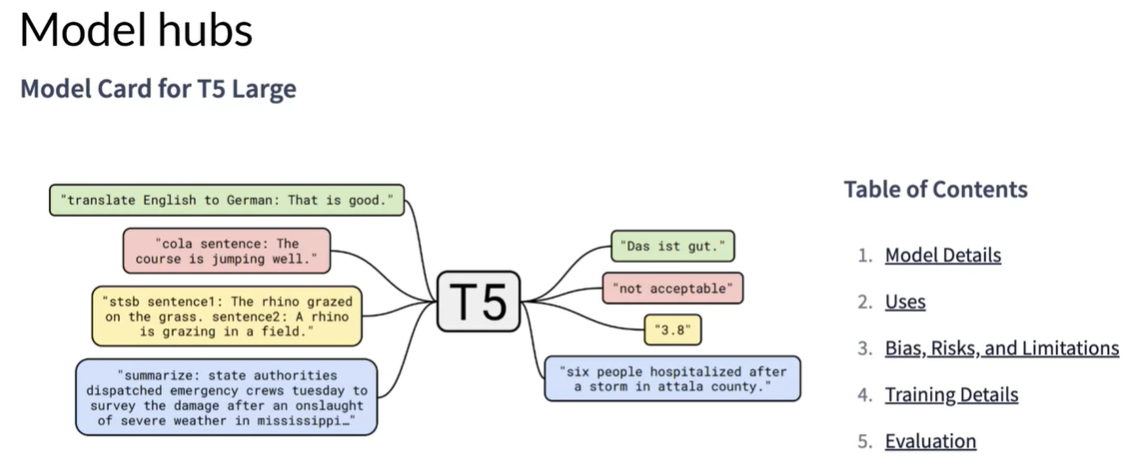

Exact model to choose depends on task we need to carry out.


### High-Level overview on training LLM

1st step is to gather the data,mostly from internet or books or other sources. Then we do data quality checks and remove the biases from data. So this leaves us only 1-3% of original tokens. after that Model uses this data to do self-supervised learning inorder to understand patterns or meaning of tokens and generates embeddings. Training objective of model is to reduce loss.

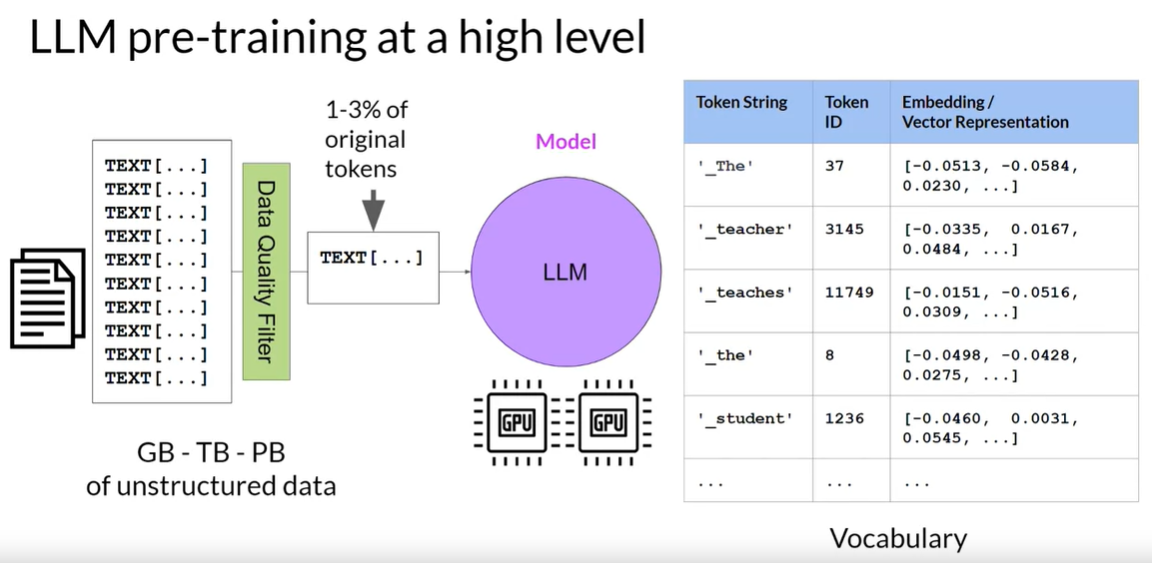

### Encoder only model (autoencoding model)

It has only encoder part of transformer architecture and pre-trained using MLM (Masked language modeling). Here tokens in the sentence are randomly masked and the training objective is to predict masked tokens inorder to reconstruct original sentence,this is also known as denoising objective. This way model learns bidirectional representation of input sentence.

**Use Cases**: 
1. Sentiment analysis
2. Named entity recognitions
3. Text Classification.

**Examples**:
Bert, Roberta

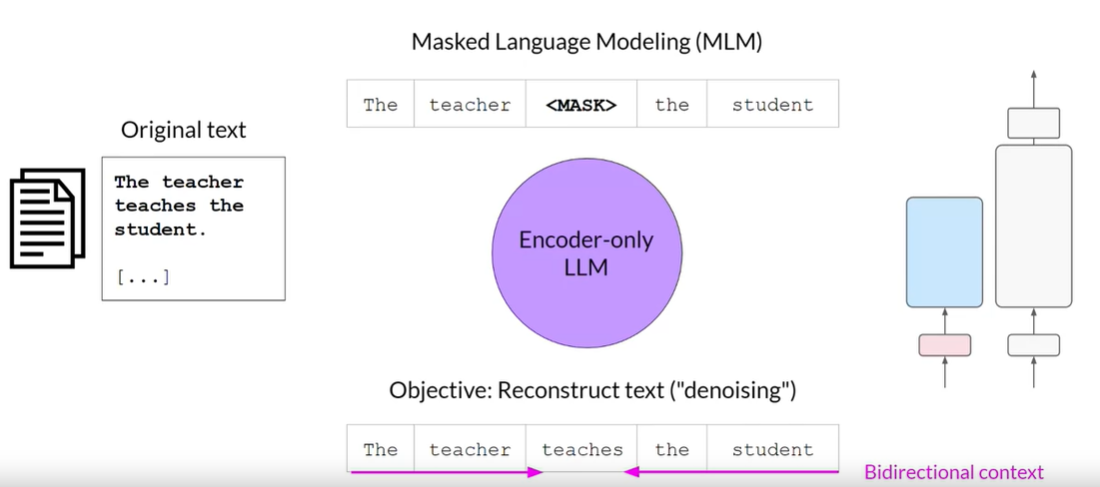

### Decoder only model (Autoregressive model)

This kind of models uses only decoder part of transformer architecture. It is pre-trained using Causal Language Modeling (CLM). While making predictions for next word it only looks at the words till the word in question. Then model iterates over the input sequence to predict next token one by one. This way model learns about language.

**Use Cases**: 
1. Text generation
2. Other emergent behaviour
    . Depends on model size

**Examples**:
GPT, BLOOM

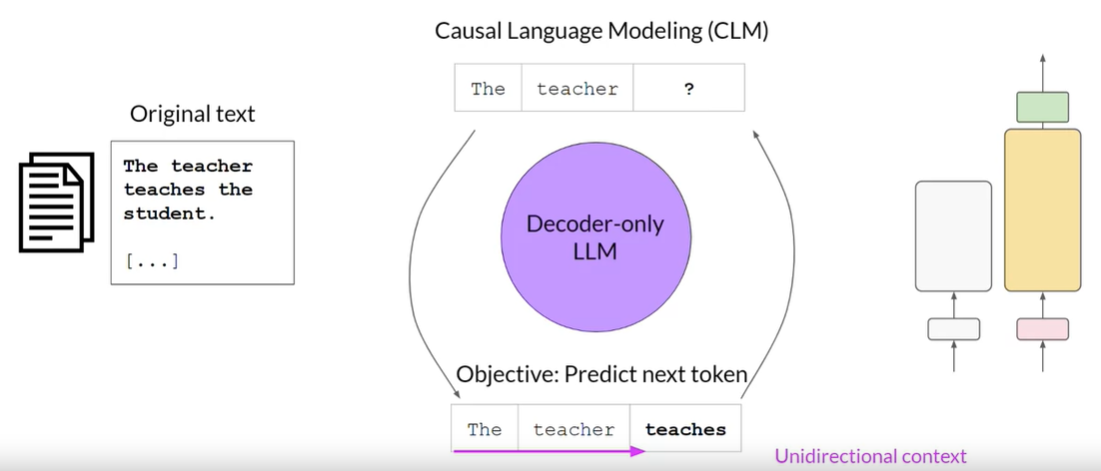

### Encoder-Decoder model (Sequence-sequence model)

These kinds of models uses both encoder and decoder part of transformer architecture. It is pre-trained using Span corruption. Here sequences are masked randomly and these sequences then mapped to unique sentinel tokens. Sentinel tokens are special tokens added to the dictionary but don't corresponds to any actual token. Then decoder's objective is to reconstruct the span. Output is sentinel tokens followed by predicted tokens.

**Use Cases**: 
1. Translation
2. Text Summarization
3. Question answering

**Examples**:
T5, BART

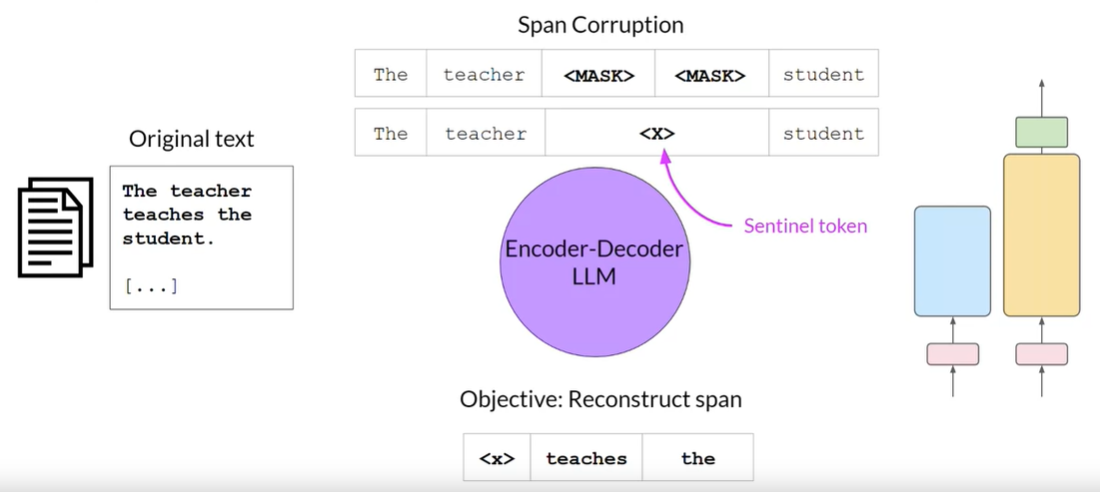

To Summarize all these into 1 page:

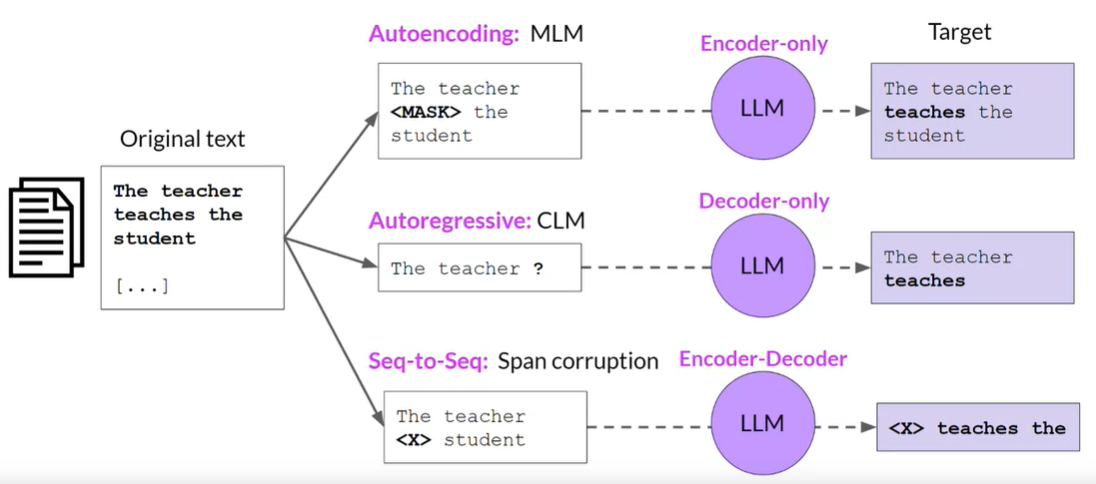


### Computational Challenges

One of the most common issue with LLM is it requires too much memory and sometimes we may run out of memory. We may get below error.

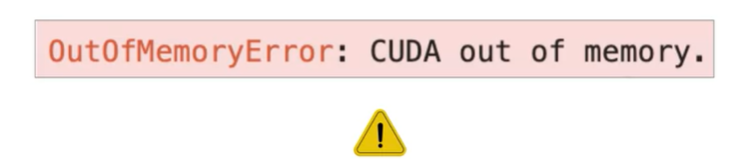

CUDA, short for Compute Unified Device Architecture, is a collection of libraries and tools developed for Nvidia GPUs. Libraries such as PyTorch and TensorFlow use CUDA to boost performance on metrics multiplication and other operations common to deep learning.

Let's understand why we need too much of memory for LLMs training:

Approximate GPU RAM needed to store 1B parameters:


1 parameter = 4 bytes(32-bit float)<br>
1B Parameter = 4 x $10^9$ bytes = 4GB @ 32-bit full precision

This is only for model parameters.

But during training, apart from model parameters we need other parameters too

| |Bytes per parameter|
| :-: | :-: |
| Model Parammeters (Weights) | 4 bytes per parameter |
| Adam optimizer (2 states) | +8 bytes per parameter |
| Gradients | +4 bytes per parameter |
| Activations and temp memory (variable size) | +8 bytes per parameter (high-end estimate) |
| Total | = 4 bytes per parameter +20 extra bytes per parameter |

So considering all of these parameters we will need 80GB memory @32-bit full precision, which is 20 times more than memory required to store the model. Which is very compute expensive for only 1 Billion parameter model training. Normally LLMs model has more than 1 Billion parameter.

### Solution

**Quantization**: It is the process of reducing data type from high precision to low precision and at end reducing memory requirements of model training process.

In this we can covert data type from FP32 (range from ~ 3 $e^{-38}$ to ~3 $e^{38}$ ) to FP16 or BFLOAT16 (half precision 16-bit floating point) or INT8. This will help reduce memory requirements for training model. 

**Quantization with FP16**

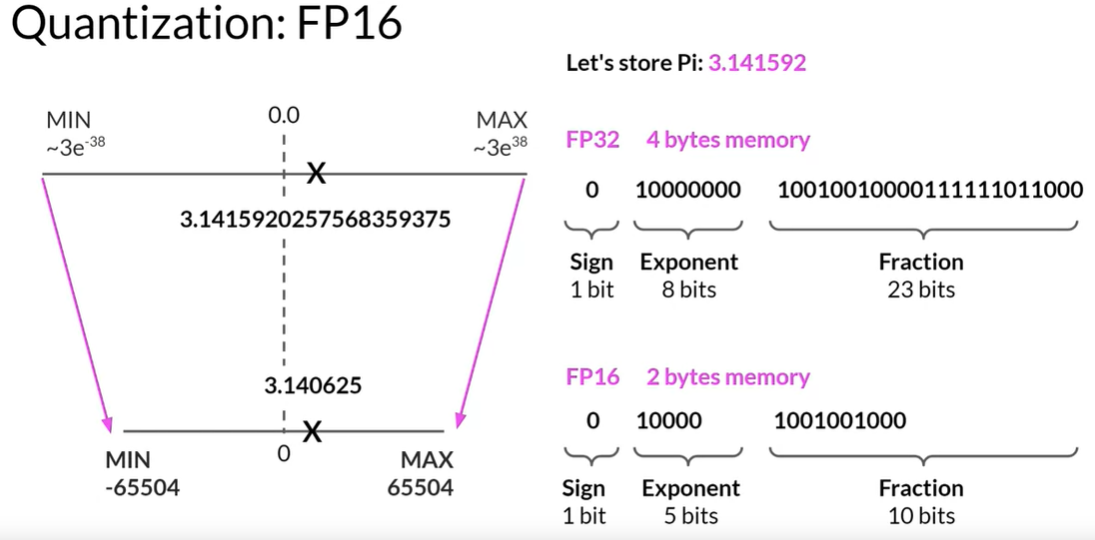

**Quantization with BF16**
BFLOAT16 is has become popular data type for many LLM. It is developed by Google Brain. It is hybrid between half precision FP16 and full precision FP32. It is also described as truncated 32-bit float as it captures full range of 32-bit float but uses only 16-bits. It uses 8 bit exponent and only 7 bits for fraction.

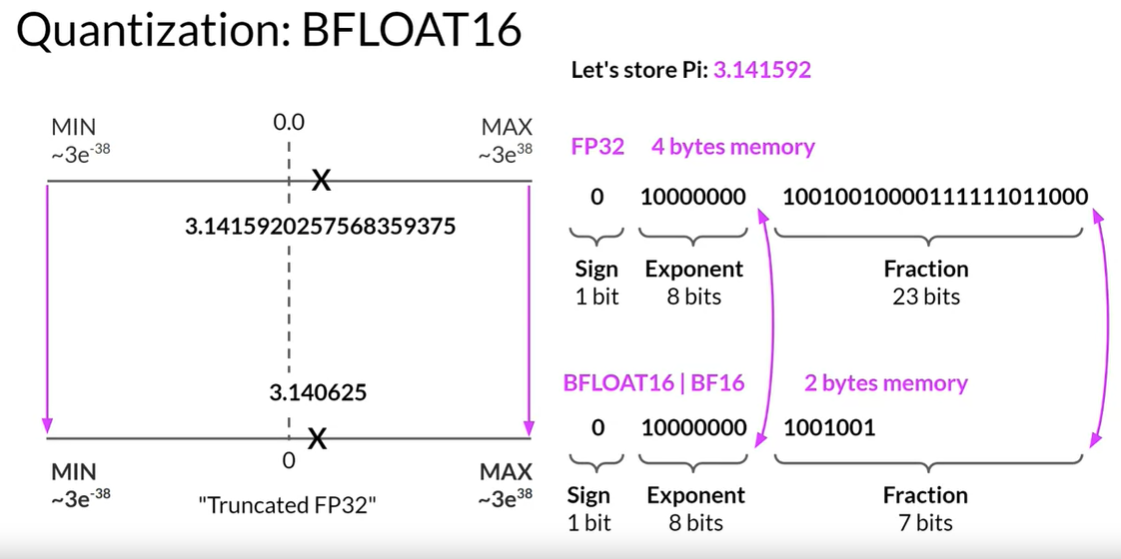

**Quantization with INT8**

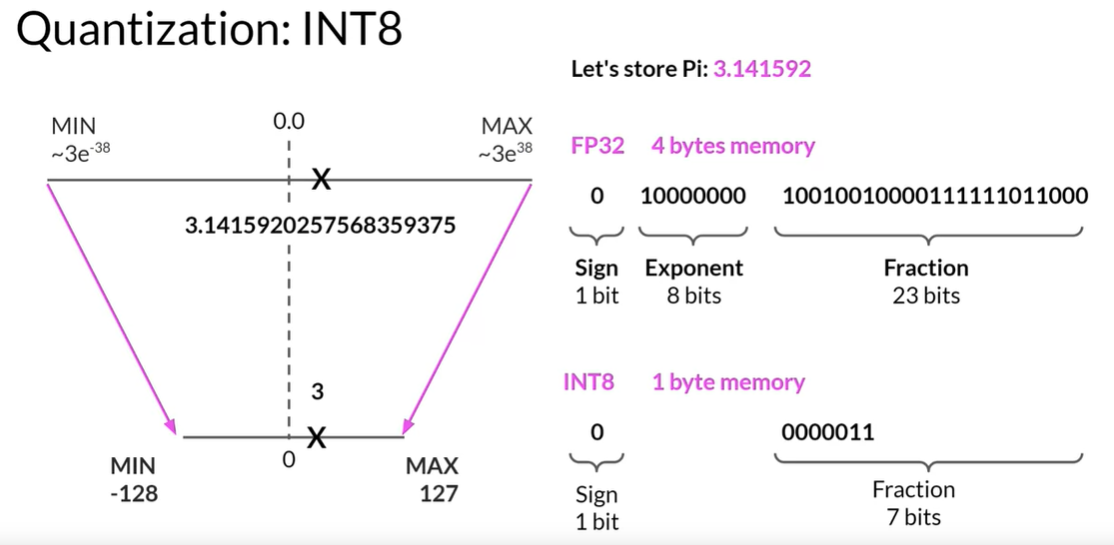

**Quantization Summary**

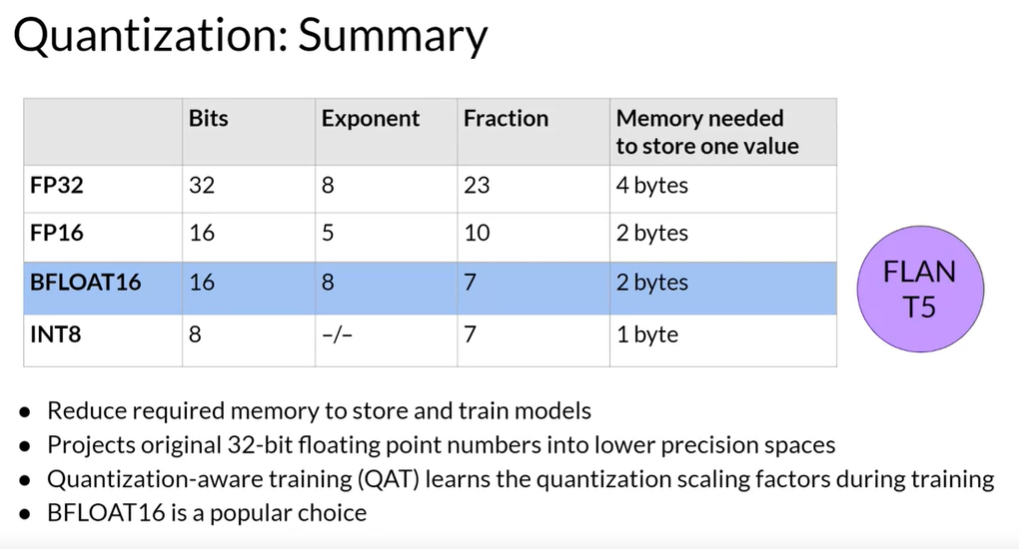

## Multi-Gpu Compute Strategy

We may need to use multi-GPU strategy when model size is very huge and would be impossible to fit on single GPU.

### DDP(Distributed Data Parallel)
In this approach data is processed in batchwise fashion on multiple GPUs. And this has implemented in pytorch distributed data-parallel or DDP for short. DDP copy model into every GPU and sends batches of data to each GPU. Each dataset is processed in parallel and then later combines results of each GPU at synchronization step. This combined model is then copied to all GPUs so that it each GPU will have its own updated copy.

This implementation allows parallel computations across all GPUs that results in faster training. <br>
**Note that DDP requires that your model weights and all of the additional parameters, gradients, and optimizer states that are needed for training, fit onto a single GPU.** 

If your model is too big for this, you should look into another technique called modal sharding

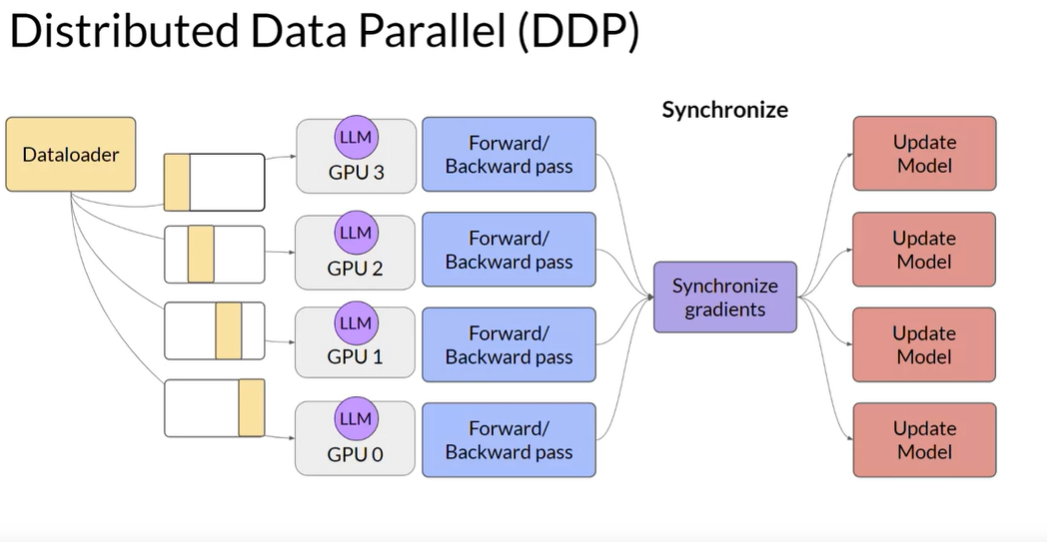

### Model Sharding

Popular implementation of model sharding is by Pytorch's **Fully Sharded Data Parallel(FSDP)** which is motivated by "ZeRo" Paper(Zero data overlap between GPUs). This helps share model across GPUs when your model doesn't fit into memory of single GPU.

**Fully Sharded Data Parallel(FSDP)**:
As learned earlier along with model parameter other parammeter such as gradient parameter, Adam optimizer parameter, activations and temp memory also consume memory while training. So rather than replicating model on each GPU, we will keep only part of it known as model shard. 

ZeRO Stage 1, shards only optimizer states across GPUs, this can reduce your memory footprint by up to a factor of four.<br>
ZeRO Stage 2 also shards the gradients across chips. When applied together with Stage 1, this can reduce your memory footprint by up to eight times.<br>
Finally, ZeRO Stage 3 shards all components including the model parameters across GPUs. When applied together with Stages 1 and 2, memory reduction is linear with a number of GPUs. For example, sharding across 64 GPUs could reduce your memory by a factor of 64.<br>

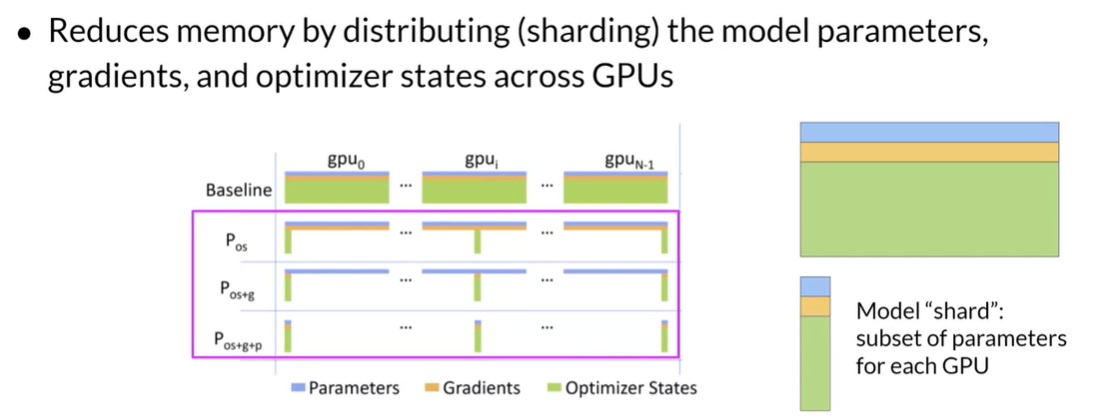

With DDP, we only distribute data across GPUs but with FSDP we also distribute or shard model parameter, optimizer states, gradient across all GPUs. Each GPU demands the data from other GPU to unshard it before Forward and backward pass. This helps model to update its parameter. After the operation it releases unsharded data back to GPUs as original sharded data.
After the backward pass, in the synchronization step it synchronizes gradients across all GPUs same way as that of DDP.

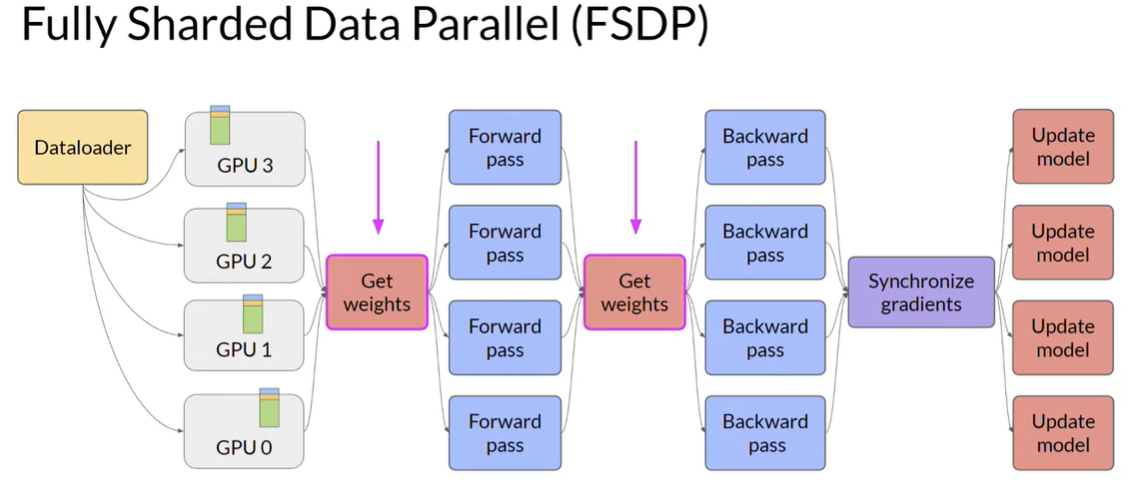

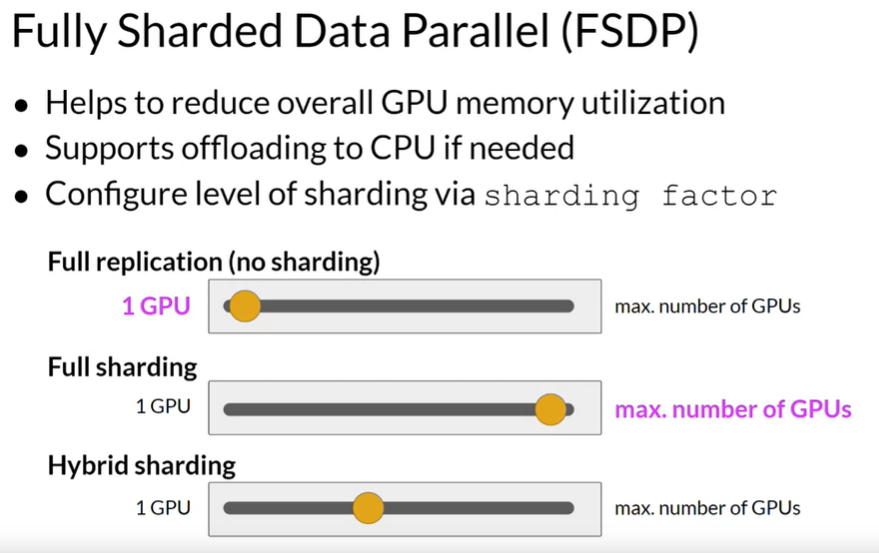

**Impact of FSDP**<br>
From below pic, we can see that even small models can use FSDP. 

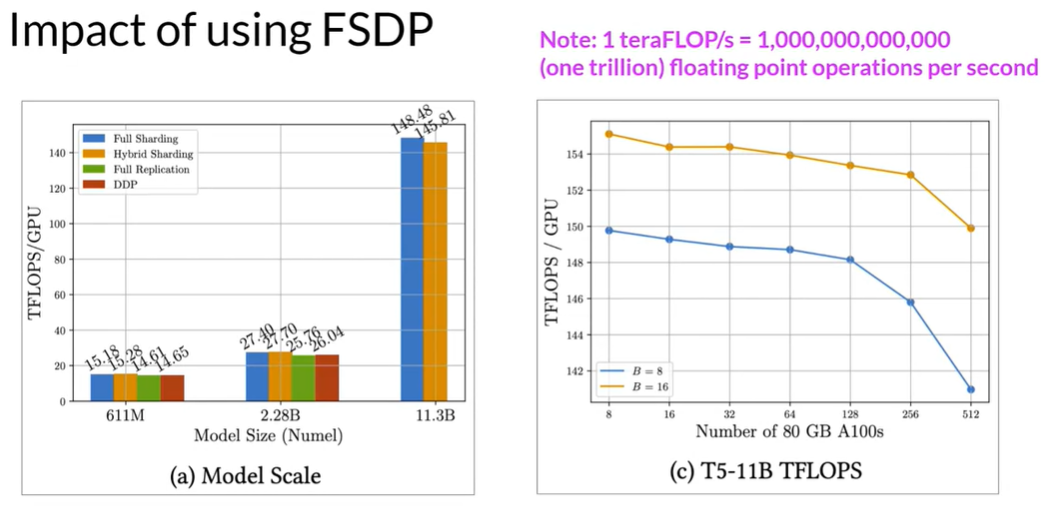